In [0]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras import backend as K

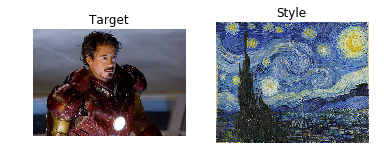

In [16]:
#@title 選擇 圖片 和 風格
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
%matplotlib inline

base_image_path = "ironman.jpg" #@param {type:"string"}
style_reference_image_path = "star.jpg" #@param {type:"string"}

plt.subplot(1, 2, 1)
plt.title("Target")
plt.axis("off")
plt.imshow(load_img(base_image_path))

plt.subplot(1, 2, 2)
plt.title("Style")
plt.axis("off")
plt.imshow(load_img(style_reference_image_path))

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols)).convert("RGB")
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [19]:
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)


model = vgg19.VGG19(input_tensor=input_tensor, include_top=False)
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [20]:
img = load_img("ironman.jpg", target_size=(img_nrows, img_ncols)).convert("RGB")
img = img_to_array(img)
img.shape

(400, 568, 3)

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


def content_loss(base, combination):
    return K.sum(K.square(combination - base))


def total_variation_loss(x):
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025



outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        # here
        grad_values = outs[1].flatten().astype('float64')
    else:
        print("error")
    return loss_value, grad_values



In [23]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()


x = preprocess_image(base_image_path)
iterations = 10
result_prefix = "style"
img_list = []
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    img_list.append(img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 4248517600.0
Image saved as style_at_iteration_0.png
Iteration 0 completed in 16s
Start of iteration 1
Current loss value: 2911303700.0
Image saved as style_at_iteration_1.png
Iteration 1 completed in 16s
Start of iteration 2
Current loss value: 2553068500.0
Image saved as style_at_iteration_2.png
Iteration 2 completed in 15s
Start of iteration 3
Current loss value: 2328735700.0
Image saved as style_at_iteration_3.png
Iteration 3 completed in 15s
Start of iteration 4
Current loss value: 2213741600.0
Image saved as style_at_iteration_4.png
Iteration 4 completed in 15s
Start of iteration 5
Current loss value: 2140377900.0
Image saved as style_at_iteration_5.png
Iteration 5 completed in 15s
Start of iteration 6
Current loss value: 2089896300.0
Image saved as style_at_iteration_6.png
Iteration 6 completed in 15s
Start of iteration 7
Current loss value: 2056211500.0
Image saved as style_at_iteration_7.png
Iteration 7 completed in 15s
Start of iterati

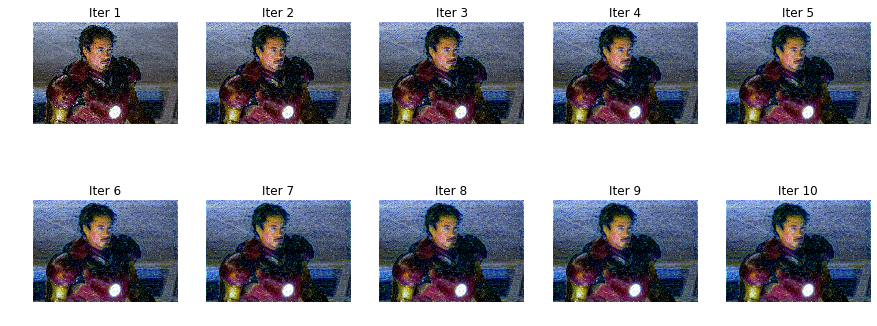

In [24]:

width = 5
height = len(img_list) // 5
plt.figure(figsize=(3 * width, 3 * height))
for i, img in enumerate(img_list):
    plt.subplot(height, width, i + 1)
    t = "Iter {}".format(i + 1)
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)